# Source

The `Source` class provides an interface and predefined methods for reading raw data from file.
If `source.use_nexus == True` the raw data will be saved and read preferentially from a generated `nexus` file, which results in a single data file with high compression and fast data access.

The `Source` class provides a `dict()` of all scans, called `scan_dict`.
The items in this dictionary are instances of the `Scan` class, which defines the common data structure.
However, the access to the scan data should NOT be done via the `scan_dict` directly, but instead for a deticated scan via `source.get_scan_data(scan_number)` or for a list of scans via `source.get_scan_list_data(scan_number_list)`.
By this all features of the `Source` class can be provided.

One key concept of the `pyEvalData` is the idea, that `Scan` instance must only provide the meta information of the scan but necessarily also its data.
By the default, the scan data will only be read on request and is then stored in the `Scan` object for later use.
It is possible, however to read all data to each scan by default by `source.read_all_data = Ture`.
On the other hand, if the data is allocating too much memory, it is possible to clear the data from the `Scan` object, directly after accessing it, via `source.read_and_forget = True`.
The flag `source.update_before_read` enables parsing the raw source file to search and add new scans before accessing any scan.
By default the last `Scan` in the `scan_dict` will always be re-created in case new data was added.
The flag `source.force_overwrite` will force a full parsing of the raw source file and a complete overwrite of the `nexus` file.

Any specific data source class must inherit from the base `Source` class and must only provide the two methods `parse_raw()` and `read_raw_ scan_data(scan)`, which parse the raw source to create the `scan_dict` and to read the actual scan data, respectivly.
With that a rather generic interface for nearly any kind of data source should be possible.

## Setup

Here we do the necessary import for this example

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np

import pyEvalData as ped

## SPEC

The most common data source are SPEC files from the original [Certif SPEC](https://certif.com/content/spec) as well as from the open-source alternative [Sardana](https://sardana-controls.org).
The `Spec` source relies on the great parser provided by [xrayutilities](https://xrayutilities.sourceforge.io).

In [131]:
spec = ped.io.Spec(file_name='certif_xu.spec', file_path='data/', use_h5=True, force_overwrite=False, update_before_read=True)

pyEvalData.io.source - INFO: Update source
pyEvalData.io.source - INFO: parse_raw
pyEvalData.io.source - INFO: Create spec_file from xrayutilities
pyEvalData.io.source - INFO: save_all_scans_to_nexus
pyEvalData.io.source - INFO: read_raw_scan_data for scan #36
pyEvalData.io.source - INFO: save_scan_to_nexus for scan #36


As described above, the scan data and meta information should be accessed via `spec.get_scan_data(scan_number)`.  
Here, `data` is returned as `numpy.recarray` and `meta` is a `dict()`.

In [133]:
data, meta = spec.get_scan_data(33)

plt.figure()
plt.imshow(np.log10(data['MCA']))
plt.title(meta['cmd'])
plt.show()

pyEvalData.io.source - INFO: Update source
pyEvalData.io.source - INFO: parse_raw
pyEvalData.io.source - INFO: save_all_scans_to_nexus
pyEvalData.io.source - INFO: read_raw_scan_data for scan #36
pyEvalData.io.source - INFO: save_scan_to_nexus for scan #36
here


AttributeError: 'NoneType' object has no attribute 'copy'

One can also directly work with the `Scan` objects, which provides nearly the same functionality as above but misses to automatically `read_and_forget` the data.
Below, the example from above is reproduces with the `Scan`. Here one can also easily access the meta information as attributes of the `Scan` instance.

In [ ]:
scan = spec.get_scan(33)

plt.figure()
plt.imshow(np.log10(scan.MCA))
plt.title(scan.cmd)
plt.show()

It is also possible to access the scan directly as attribute of the source which is fully aquivalent to the last example

In [ ]:
plt.figure()
plt.imshow(np.log10(spec.scan33.MCA))
plt.title(spec.scan33.cmd)
plt.show()

## Composite Sources

On specific idea of the `Source` class is to provide also composite models of pre-defined `Source` classes.
An example is the `Spec` source for reading SPEC data files and a `Source` class to read camera images from a folder structure, that have been acquired simultaneously with the SPEC file.
This would require to specify the two independent `Souce` objects and then add them to a single `CompositeSource`:
```python
spec = ed.io.Spec(file_name, file_path)
ccd = ed.io.Pilatus(image_pattern, image_base_path)

comp_source = spec + ccd
```

## Nexus

In [54]:
from nexusformat.nexus import *
import os.path as path

from nexusformat.nexus.completer import load_ipython_extension

load_ipython_extension(get_ipython())

NameError: name 'NeXusError' is not defined

In [47]:
nxs_file = nxload(path.join(spec.nexus_file_path, spec.nexus_file_name), mode='rw')

In [52]:
data2D=NXdata()
nxs_file.NXentry

[]

In [59]:
a = NXentry(name='entry33')

In [108]:
with nxs_file.nxfile:
    nxs_file['entry36'] = NXentry()
    nxs_file['entry36'].epoch = 101
    nxs_file['entry36'].command = spec.scan36.cmd
    nxs_file['entry36'].date = spec.scan36.date
    nxs_file['entry36'].time = spec.scan36.time
    nxs_file['entry36'].int_time = spec.scan36.int_time
    nxs_file['entry36/data'] = NXcollection()
    nxs_file['entry36/data/omega'] = NXfield(spec.scan36.data.omega)
    nxs_file['entry36/data/omega'].units = 'K'
    nxs_file['entry36/data/MCA'] = NXfield(spec.scan36.data.MCA)
    nxs_file['entry36/init_mopo'] = NXcollection()
    nxs_file['entry36/init_mopo/delta'] = NXfield(spec.scan36.meta['init_mopo']['INIT_MOPO_delta'])

In [109]:
print(nxs_file.tree)

root:NXroot
  @HDF5_Version = '1.12.0'
  @file_name = 'C:\Users\loc_schick\General\git\pyEvalData\doc...'
  @file_time = '2021-11-10T10:32:22.076777'
  @h5py_version = '3.1.0'
  @nexusformat_version = '0.7.1'
  entry33:NXentry
    data:NXdata
  entry34:NXentry
  entry35:NXentry
  entry36:NXentry
    command = ' a2scan  om  42.054  44.054  gam  84.0943  88.0943  400  2'
    data:NXcollection
      MCA = uint32(401x2048)
      omega = float64(401)
        @units = 'K'
    date = 'Sun Oct 31 2010'
    epoch = 101
    init_mopo:NXcollection
      delta = 0.0
    int_time = 2.0
    time = '16:21:51'


In [107]:
del nxs_file['entry36']

In [96]:
spec.scan35.meta['init_mopo']['INIT_MOPO_delta']

0.0

In [70]:
print(nxs_file.tree)

root:NXroot
  @HDF5_Version = '1.12.0'
  @file_name = 'C:\Users\loc_schick\General\git\pyEvalData\doc...'
  @file_time = '2021-11-10T10:32:22.076777'
  @h5py_version = '3.1.0'
  @nexusformat_version = '0.7.1'
  entry33:NXentry
    data:NXdata


In [126]:
for name in spec.scan35.data.dtype.names:
    print(name)

omega
gamma
Epoch
Seconds
Ion_m1
Ion_m2
srcur
curratt
detcorr
ratio
ACEdet
all2
psd2
dir2
refl2
yoneda2
ccdint
twago
bpmi
vpulses
tlangm
vO2
apdcnt
apdtemp
Monitor
Detector
MCA


In [99]:
a=nxload('data/sardana_nexus.h5')

In [100]:
print(a.tree)

root:NXroot
  @HDF5_Version = '1.10.4'
  @creator = 'NXscanH5_FileRecorder'
  @file_name = '/home/labuser/data/commissioning/2020_09_commi...'
  @file_time = '2020-11-18T13:18:29.120845'
  @h5py_version = '2.10.0'
  entry1:NXentry
    @epoch = 1605776490.651113
    definition = 'NXscan'
    entry_identifier = '1'
    measurement:NXcollection
      Pt_No = 0
      ccd_height = -5.0
      delay_stage = 1.496875
      dt = []
      epoch = 1605772891.1765575
        @units = ''
      mte = float64(1x4096x4096)
        @units = ''
      pm = 2.2295665624999996
        @units = ''
      pre_scan_snapshot:NXcollection
        ccd_height = -5.0
        delay_stage = 1.496875
        pm = 2.2266074874999995
        rzp_chi = 0.0
        rzp_phi = 2.79996693
        rzp_theta = 0.0
        rzp_x = 0.0
        rzp_y = 0.0
        rzp_z = -4.0
        slit_hor = 31.4125
        slit_ver = 44.582499999999996
        th = -7.553e-06
        tth = -10.000031249999996
        xs = -0.0001832739999998

In [23]:
a.entry288.measurement.mte

NXfield(shape=(21, 492, 512), dtype=float64)

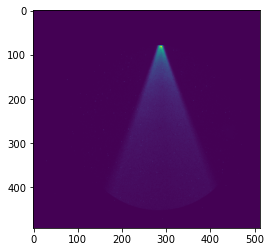

In [25]:
plt.figure()
plt.imshow(a.entry288.measurement.mte[10, :, :])
plt.show()

In [26]:
data = a.entry288.measurement

In [36]:
for field in data:
    print(field)
    print(np.asarray(data[field]))

Pt_No
[ 0  1  2 ... 18 19 20]
ccd_height
0.0
delay
9.986075099994677
delay_stage
1.496875
dt
[ 1.929115  4.996096  8.037    ... 63.359888 66.947102 70.574375]
epoch
[1.605889e+09 1.605889e+09 1.605889e+09 ... 1.605889e+09 1.605889e+09
 1.605889e+09]
mte
[[[577. 580. 585. ... 583. 578. 579.]
  [579. 589. 588. ... 576. 587. 594.]
  [578. 582. 582. ... 581. 585. 585.]
  ...
  [587. 599. 596. ... 598. 593. 595.]
  [601. 604. 596. ... 601. 594. 593.]
  [611. 618. 605. ... 611. 602. 600.]]

 [[580. 589. 589. ... 583. 575. 580.]
  [575. 587. 586. ... 585. 589. 581.]
  [578. 585. 583. ... 588. 586. 595.]
  ...
  [592. 595. 597. ... 599. 597. 590.]
  [594. 601. 597. ... 604. 601. 599.]
  [601. 610. 610. ... 609. 605. 604.]]

 [[580. 583. 585. ... 585. 584. 580.]
  [583. 580. 583. ... 586. 575. 582.]
  [592. 585. 582. ... 582. 579. 587.]
  ...
  [594. 586. 591. ... 596. 594. 596.]
  [607. 593. 602. ... 590. 596. 593.]
  [613. 603. 611. ... 608. 614. 613.]]

 ...

 [[582. 582. 583. ... 578. 583. 

NeXusError: '__array_struct__' not in /entry288/measurement/pre_scan_snapshot

In [33]:
np.asarray(data.mte[()])

array([[[577., 580., 585., ..., 583., 578., 579.],
        [579., 589., 588., ..., 576., 587., 594.],
        [578., 582., 582., ..., 581., 585., 585.],
        ...,
        [587., 599., 596., ..., 598., 593., 595.],
        [601., 604., 596., ..., 601., 594., 593.],
        [611., 618., 605., ..., 611., 602., 600.]],

       [[580., 589., 589., ..., 583., 575., 580.],
        [575., 587., 586., ..., 585., 589., 581.],
        [578., 585., 583., ..., 588., 586., 595.],
        ...,
        [592., 595., 597., ..., 599., 597., 590.],
        [594., 601., 597., ..., 604., 601., 599.],
        [601., 610., 610., ..., 609., 605., 604.]],

       [[580., 583., 585., ..., 585., 584., 580.],
        [583., 580., 583., ..., 586., 575., 582.],
        [592., 585., 582., ..., 582., 579., 587.],
        ...,
        [594., 586., 591., ..., 596., 594., 596.],
        [607., 593., 602., ..., 590., 596., 593.],
        [613., 603., 611., ..., 608., 614., 613.]],

       ...,

       [[582., 582., 583